In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.sparse.linalg

from time import time

# install this with "pip install datafold"
import datafold.pcfold as pfold

from large_eigensystems import *
from test_efficiency import *

In [99]:
# notebook parameters
n_timepoints = 10
n_pts = 2000
kernel_tol = -1
_time = np.linspace(0,1,n_timepoints)

In [115]:
class TestControlSystem(TestEfficiency):
    def __init__(self, sensor1, sensor2, n_timepoints, **kwargs):
        super(TestControlSystem, self).__init__(sensor1, sensor2, **kwargs)
        self.n_timepoints = n_timepoints
        
    def pid(y_setpoint, y_processvariable, ka,kb,kc, dt):
        """
        standard PID controller
        """
        # P part
        eP = (y_setpoint - y_processvariable[-1])
        # I part (not here)
        eI = np.sum(y_setpoint - y_processvariable) / y_processvariable.shape[0]
        # D part (not here)
        eD = ((y_setpoint - y_processvariable[-1]) - (y_setpoint - y_processvariable[0])) / dt
        res = ka * eP + kb * eI + kc * eD
        return res

    @staticmethod
    def pendulum_1d_ode(y,t,u):
        """
        the pendulum system
        """
        g = 1
        m = 1
        k = .0
        l = 1
        dy = np.zeros(2,)
        dy[0] = y[1]
        dy[1] = -g/l * np.sin(y[0]) - k/(m*l) * y[1] + u(t)
        return dy
    
    def setup_example(self,):
        t0 = time()
        
        rng = np.random.default_rng(self.random_seed)

        _time = np.linspace(0,1,self.n_timepoints)
        _y0s = rng.uniform(low=-np.pi,high=np.pi,size=(self.n_pts,3))
        _y0s[:,2] = (_y0s[:,2] + np.pi)/(2*np.pi) # move _y0s[:, 2] to [0,1] range
        
        _all_states = []
        _all_controls = []
        for k in range(self.n_pts):
            y0 = _y0s[k, :2]*0+np.pi
            _u0 = _y0s[k, 2]
            def _u(t):
                return 10.0*(np.tanh((t-_u0)*10)/2+1/2)
            generate_data = scipy.integrate.odeint(self.pendulum_1d_ode, t=_time, y0=y0, args=(_u,))

            _states = np.column_stack([
                    np.cos(generate_data[:,0]),
                    np.sin(generate_data[:,0]),
                    generate_data[:,1]])#.ravel()
            _controls = _u(_time)
            
            _states = _states[-1,:]
            _controls = np.sum(_controls)/10
            
            _all_states.append(_states)
            _all_controls.append(_controls)

        _all_states = np.row_stack(_all_states)
        _all_controls = np.row_stack(_all_controls)
        
        s1 = self.sensor1(_all_states, _all_controls)
        s2 = self.sensor2(_all_states, _all_controls)
        
        self.time_data["time_example"] = time()-t0
        return s1, s2, s2

def sensor1(_observables,_controls):
    return _controls*2
def sensor2(_observables,_controls):
    return _controls

_te = TestControlSystem(sensor1=sensor1, sensor2=sensor2,
                        n_timepoints=n_timepoints, n_pts=n_pts,
                        n_common_evecs=5, n_kernel_evecs=500,
                        compute_sparse=False,
                        kernel_tol=kernel_tol,
                        cutoff_result_scaling=5)

In [116]:
s1, s2, _ = _te.setup_example()
print(s1.shape)
print(s2.shape)

(2000, 1)
(2000, 1)


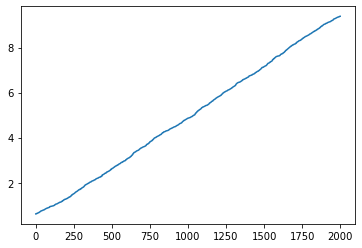

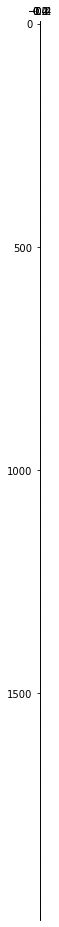

In [117]:
# plt.matshow(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(s2)))
#plt.matshow(np.sort(s2,axis=0)[::-1,:][0::50,:], vmin=0,vmax=10)

plt.plot(np.sum(np.sort(s2,axis=0), axis=1));

plt.matshow(s2)

In [118]:
if False:
    idx_plot = np.arange(0,min(s1.shape[0], 20))
    cmap1 = "winter"
    cmap2 = "bwr"
    m_s = 5

    fig,ax=plt.subplots(1,3,figsize=(3*4,3),sharey=True)

    for k in range(len(ax)):
        ax[k].plot(_time, *s1[k,:].reshape(-1,3)[:,[0]].T)
        ax[k].plot(_time, *s1[k,:].reshape(-1,3)[:,[1]].T)
        ax[k].plot(_time, s2[k,:]/np.max(s2[k,:]), ':')
        ax[k].set_title("Control vs. States")
        ax[k].set_xlabel(r"time")
        if k==0:
            ax[k].set_ylabel(r"control")

    fig.tight_layout()

Time for kernel 1: 0.10671520233154297
Sparsity of kernel 1: 10.6895 percent
Time for kernel 2: 0.10372281074523926
Sparsity of kernel 2: 10.596400000000001 percent
computing first eigensystem... done
computing second eigensystem... done
(2000, 624)


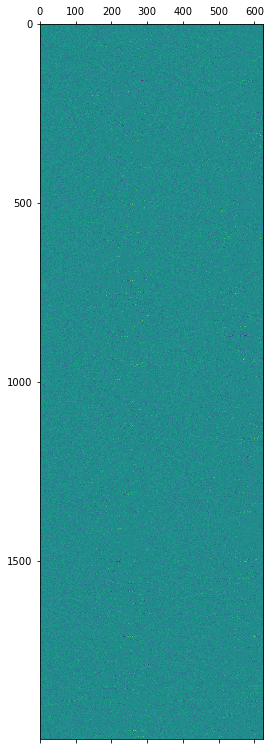

In [119]:
k1, k2 = _te.compute_kernels()

CE = CommonEigensystemMatrix(k1, k2, kernel_tol=_te.kernel_tol, kernel_evecs=_te.n_kernel_evecs,
                             verbose=_te.verbose, evec_tol=_te.evec_tol)

_te.time_data["time_eig_k1"] = CE.time_data["time_eig_k1"]
_te.time_data["time_eig_k2"] = CE.time_data["time_eig_k2"]

print(CE.rows.shape)

plt.matshow(CE.rows)

In [120]:
if False and _te.compute_sparse:
    t0=time()
    Cevecs_sparse,Cevals_sparse,_ = scipy.sparse.linalg.svds(CE.rows, k=_te.n_common_evecs)#,
                                                             #which='LM')#, tol=_te.evec_tol)
    _te.time_data["time_common"] = time()-t0

    #self.__log(f"Time for sparse SVD {time()-t0}")
    Cevals,Cevecs = CE._sort_eigensystem(Cevals_sparse, Cevecs_sparse)

else:
    t0=time()
    Cevecs_dense,Cevals_dense,_ = scipy.linalg.svd(CE.rows+np.random.normal(loc=0,scale=1e-4,size=CE.rows.shape))
    _te.time_data["time_common"] = time()-t0

    #self.__log(f"Time for dense SVD {time()-t0}")

    Cevals,Cevecs = CE._sort_eigensystem(Cevals_dense, Cevecs_dense)

#return Cevals, Cevecs

In [95]:
Cevals, Cevecs = _te.compute_common_system()

Time for kernel 1: 0.03295183181762695
Sparsity of kernel 1: 45.81277777777778 percent
Time for kernel 2: 0.022938013076782227
Sparsity of kernel 2: 27.928888888888885 percent
computing first eigensystem... done
computing second eigensystem... done
Time for dense SVD 0.16066408157348633


In [200]:

def mykernelmatrix(self, data, eps = None, use_cknn=True):
    if eps is None:
        _pcm = pfold.PCManifold(data, dist_kwargs=dict(backend="scipy.kdtree"))
        _pcm.optimize_parameters(result_scaling=25)
        #_pcm.cut_off = np.inf
        #_pcm.kernel.epsilon = 1
    else:
        _k = pfold.kernels.GaussianKernel(epsilon=eps)
        _pcm = pfold.PCManifold(data, kernel=_k, dist_kwargs=dict(backend="scipy.kdtree"))
    
    if use_cknn:
        k_neighbor = 50
        delta = 0.5
        _k=pfold.kernels.ContinuousNNKernel(k_neighbor=k_neighbor, delta=delta)
        
        _pcm = pfold.PCManifold(data, kernel=_k,
                                dist_kwargs={"backend": 'scipy.kdtree', 'kmin': k_neighbor})
        
    
    if use_cknn:
        _k,_ = _pcm.compute_kernel_matrix()
        _k = (_k+_k.T)/2
    else:
        _k = _pcm.compute_kernel_matrix()
    res = scipy.sparse.csr_matrix(_k)
    
    if False:
        Qhalf = scipy.sparse.diags(np.sqrt(np.array(1/res.sum(axis=0)).ravel()), 0)
        res = Qhalf @ res @ Qhalf
    if False:
        Qhalf = scipy.sparse.diags((np.array(1/res.sum(axis=1)).ravel()), 0)
        res = Qhalf @ res# @ Qhalf
        #res.eliminate_zeros()
    if True:
        QR = scipy.sparse.diags(np.array(1/res.sum(axis=0)).ravel(), 0)
        res = res @ QR
    
    if not(use_cknn):
        print("epsilon", _pcm.kernel.epsilon)
    print("cutoff", _pcm.cut_off)

    return res

_rng =np.random.default_rng(1)
s1 = np.sort(_rng.uniform(low=0,high=1,size=(n_pts,1)))
s2 = s1*2

#newdata = np.linspace(0,1,1000).reshape(-1,1) # np.sum(s2,axis=1).reshape(-1,1)
#newdata = np.sum(s2,axis=1).reshape(-1,1)
newdata = s1
_kk = mykernelmatrix(_te, newdata)#, eps=15)
#_kk = k1

# use random initial state
v0 = np.random.rand(_kk.shape[0],)

# solve both kernel problems
n_evecs = np.min([CE.kernel_evecs, _kk.shape[0]])

Aevals,Aevecs = scipy.sparse.linalg.eigsh(_kk, k=n_evecs)#,  tol=cE.evec_tol)
Aevals,Aevecs = CE._sort_eigensystem(Aevals,Aevecs)

newdata = s2
_kk = mykernelmatrix(_te, newdata)#, eps=15)
#_kk = k1

# use random initial state
v0 = np.random.rand(_kk.shape[0],)

# solve both kernel problems
n_evecs = np.min([CE.kernel_evecs, _kk.shape[0]])

Bevals,Bevecs = scipy.sparse.linalg.eigsh(_kk, k=n_evecs)#,  tol=cE.evec_tol)
Bevals,Bevecs = CE._sort_eigensystem(Bevals,Bevecs)

kernel_tol = 1e-8
CErows = np.column_stack([Aevecs[:,Aevals>kernel_tol],Bevecs[:,Bevals>kernel_tol]])
Cevecs_,Cevals_,_ = scipy.linalg.svd(CErows)
Cevals,Cevecs = CE._sort_eigensystem(Cevals_, Cevecs_)

print(np.sum(Aevals>kernel_tol))
print(np.sum(Bevals>kernel_tol))
print(Cevals.shape)

cutoff inf
cutoff inf
290
290
(580,)


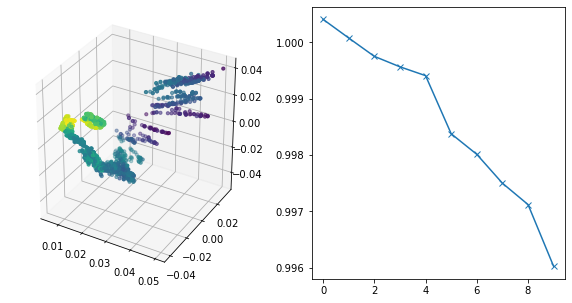

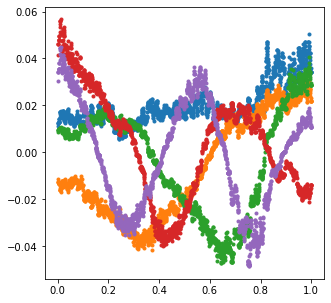

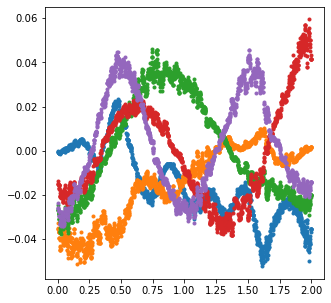

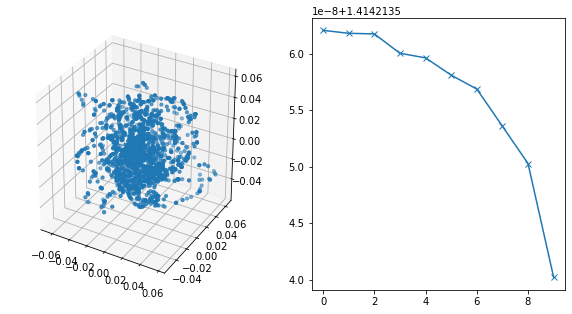

In [201]:
#Aevecs = CE.rows[:,500:]

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(121,projection='3d')
ax.scatter(*Aevecs[:,[0,1,2]].T, s=10, c=Bevecs[:,0])
ax=fig.add_subplot(122)
ax.plot(Aevals[:10], 'x-')

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
ax.plot(s1[:,0],Aevecs[:,:5], '.')

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
ax.plot(s2[:,0],Bevecs[:,:5], '.')

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(121,projection='3d')
ax.scatter(*Cevecs[:,[0,1,2]].T, s=10)
ax=fig.add_subplot(122)
ax.plot(Cevals[:10], 'x-')

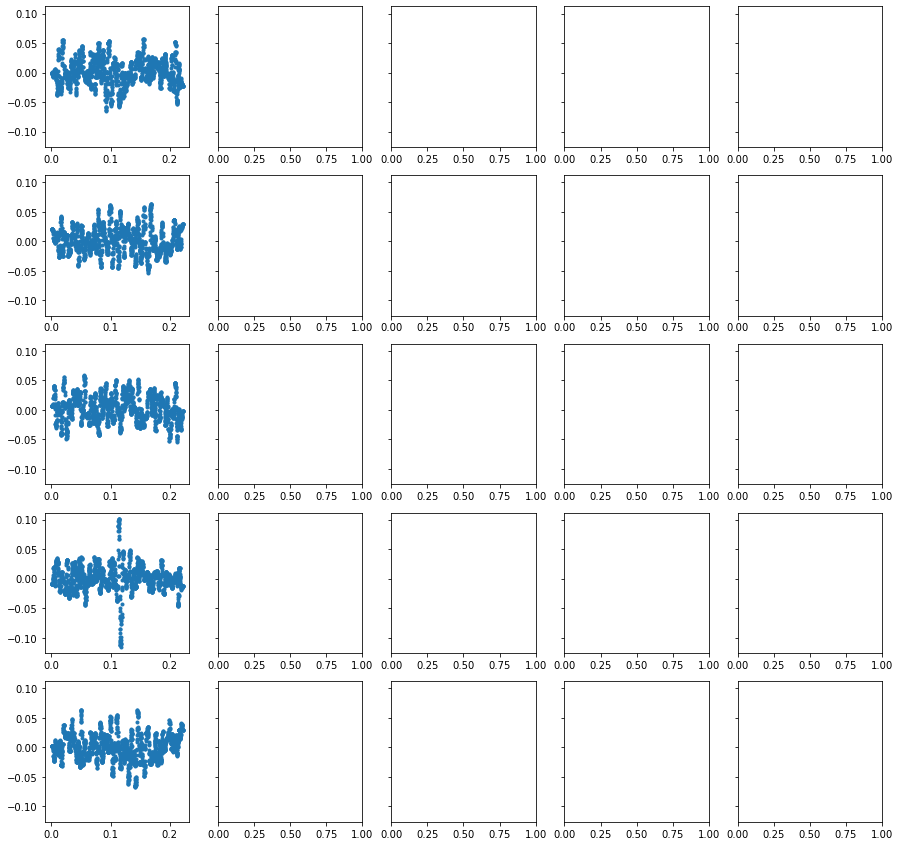

In [202]:
n_plots = 5
fig,ax=plt.subplots(5,n_plots,figsize=(n_plots*3,5*3),sharey=True)

for k in range(ax.shape[0]):
    _idx = np.argsort(Cevecs[:,k])
    #for l in range(ax.shape[1]):
    #ax[k,l].imshow(s2[_idx,:][np.arange(0,25)+250*l,:])
    ax[k,0].plot(np.sum(s2, axis=1)*(_time[1]-_time[0]), Cevecs[:,k], '.')

In [75]:
_te.time_data

{'n_pts': 5000,
 'n_kernel_evecs': 500,
 'n_common_evecs': 10,
 'random_seed': 1,
 'time_example': 8.337899923324585,
 'time_k1': 2.4945836067199707,
 'mat_sparsity_k1': 1.87,
 'time_k2': 0.7983589172363281,
 'mat_sparsity_k2': 0.92232,
 'time_eig_k1': 12.747859239578247,
 'time_eig_k2': 5.400874376296997,
 'time_common': 0.7948787212371826}